In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from datasets import load_dataset
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
SEED = 1234

# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")



Using cuda device


In [67]:
# Load the IMDb review dataset
imdb_dataset = load_dataset("imdb")

# Split the dataset into train and validation sets
train_texts, train_labels = imdb_dataset['train']['text'], imdb_dataset['train']['label']
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, stratify=train_labels, random_state=SEED)

# Combine the train and validation sets
train_dataset = {'text': train_texts, 'label': train_labels}
val_dataset = {'text': val_texts, 'label': val_labels}


  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:

# Tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Define functions for text preprocessing
def clean(text, tokenizer):
    text = text.lower()
    text = tokenizer.tokenize(text)
    return text

# Create word to index mapping
def get_word2idx(corpus, tokenizer, minlen=100, maxlen=500):
    word2idx = {}
    idx = 1
    for sentence in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):
        sentence = clean(sentence, tokenizer)
        if len(sentence) < minlen or len(sentence) > maxlen:
            continue
        for word in sentence:
            if word not in word2idx:
                word2idx[word] = idx
                idx += 1
    return idx, word2idx



In [ ]:
vocab_size, word2idx = get_word2idx(train_dataset['text'], tokenizer)

In [15]:


class IMDBDataset(Dataset):
    def __init__(self, dataset, word2idx, minlen=100, maxlen=500):
        self.dataset = dataset
        self.word2idx = word2idx
        self.minlen = minlen
        self.maxlen = maxlen
        self.count = 0
        self.inputs = []
        self.targets = []

        for idx, sentence in tqdm(enumerate(self.dataset['text']), total=len(self.dataset['text']), desc="Transforming input text"):
            sentence = clean(sentence, tokenizer)
            if len(sentence) < minlen or len(sentence) > maxlen:
                continue
            self.count += 1
            indexed_sentence = [self.word2idx.get(word, 0) for word in sentence]
            self.inputs.append(torch.tensor(indexed_sentence))
            self.targets.append(torch.tensor(self.dataset['label'][idx]))

        # Pad the sentences to maxlen
        self.inputs = pad_sequence(self.inputs, batch_first=True, padding_value=0)

    def __len__(self):
        return self.count

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]


# Create the train, validation, and test datasets
train_ds = IMDBDataset(train_dataset, word2idx)
val_ds = IMDBDataset(val_dataset, word2idx)
test_ds = IMDBDataset(imdb_dataset['test'], word2idx)



Transforming input text: 100%|██████████| 25000/25000 [05:13<00:00, 79.83it/s] 


In [16]:
# Create DataLoader instances
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        logits = self.fc(output[:, -1, :])
        return logits


In [17]:

# Hyperparameters
embedding_dim = 128
hidden_size = 256
num_classes = 2
learning_rate = 1e-3
num_epochs = 5

# Create the model
model = RNNModel(vocab_size, embedding_dim, hidden_size, num_classes).to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()





In [18]:

# Model training
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    train_losses = []
    val_losses = []
    val_accuracy = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)
        val_accuracy.append(correct / total)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {correct/total:.4f}")

    return train_losses, val_losses, val_accuracy

# Train the model
train_losses, val_losses, val_accuracy = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:00<00:00, 221.33it/s]


Epoch 1/5, Train Loss: 0.7071, Val Loss: 0.6985, Val Acc: 0.4898


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:00<00:00, 241.40it/s]


Epoch 2/5, Train Loss: 0.7019, Val Loss: 0.7341, Val Acc: 0.5082


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:00<00:00, 246.40it/s]


Epoch 3/5, Train Loss: 0.7015, Val Loss: 0.6982, Val Acc: 0.5075


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:00<00:00, 245.76it/s]


Epoch 4/5, Train Loss: 0.7047, Val Loss: 0.6946, Val Acc: 0.5100


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:00<00:00, 246.59it/s]

Epoch 5/5, Train Loss: 0.7002, Val Loss: 0.6970, Val Acc: 0.4943


In [19]:
# Test the model
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted== targets).sum().item()
    test_loss /= len(test_loader)
    test_accuracy = correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Load the best model and test it
best_model = RNNModel(vocab_size, embedding_dim, hidden_size, num_classes).to(device)
best_model.load_state_dict(torch.load('best_model.pth'))
test_model(best_model, test_loader, criterion)


Testing: 100%|██████████| 628/628 [00:02<00:00, 246.49it/s]

Test Loss: 0.6945, Test Accuracy: 0.5095


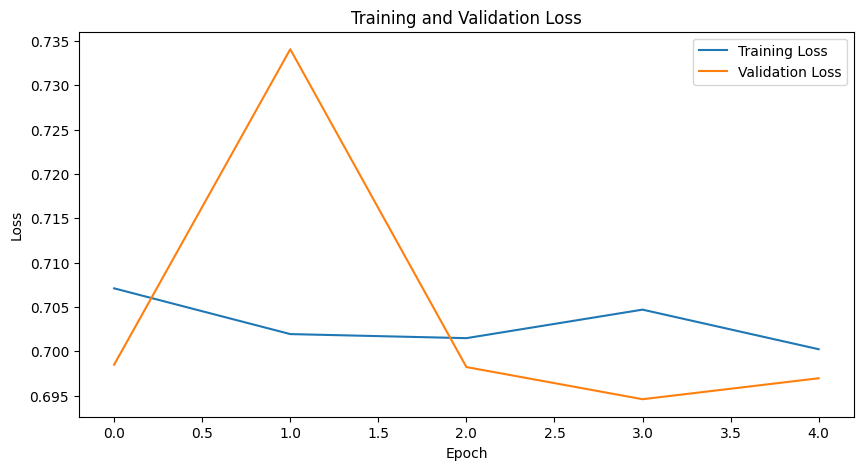

In [22]:
import matplotlib.pyplot as plt
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()




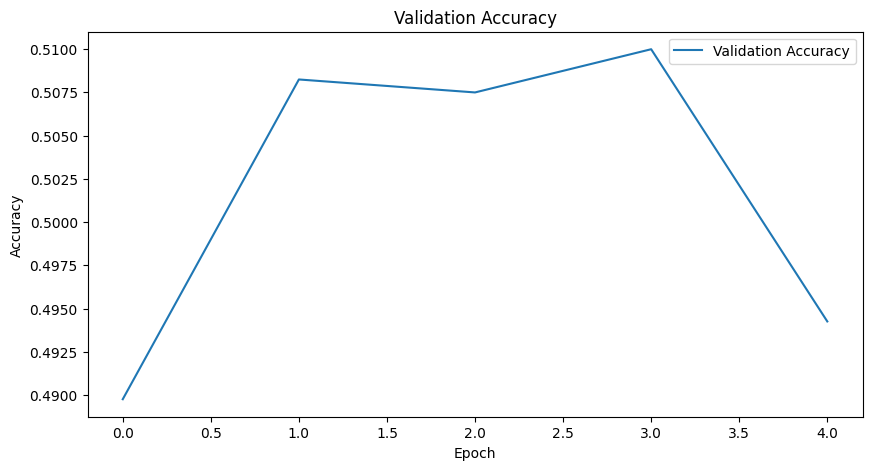

In [23]:
# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

#### 1.2 Incorporate stemming/lemmatization when doing text preprocessing using the NLTK library. What changes do you observe in accuracy ?

In [86]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
# import nltk
# nltk.download('wordnet')

def clean(text, tokenizer, lemmatizer):
    text = text.lower()
    text = tokenizer.tokenize(text)
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

# Tokenizer and Lemmatizer
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()


In [69]:
!mkdir nltk_data


mkdir: cannot create directory 'nltk_data': File exists


In [70]:
import nltk
nltk.download("wordnet", download_dir="nltk_data/")


[nltk_data] Downloading package wordnet to nltk_data/...
[nltk_data]   Package wordnet is already up-to-date!


True

In [72]:
nltk.data.path.append('./nltk_data/')


In [63]:

import nltk

nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [88]:

# Create word to index mapping
def get_word2idx(corpus, tokenizer, minlen=100, maxlen=500):
    word2idx = {}
    idx = 1
    for sentence in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):
        sentence = clean(sentence, tokenizer, lemmatizer)
        if len(sentence) < minlen or len(sentence) > maxlen:
            continue
        for word in sentence:
            if word not in word2idx:
                word2idx[word] = idx
                idx += 1
    return idx, word2idx


In [84]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [87]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize('dogs'))


dog


In [89]:
vocab_size, word2idx = get_word2idx(train_dataset['text'], tokenizer)

Creating word2idx: 100%|██████████| 20000/20000 [00:29<00:00, 682.11it/s]


In [91]:

class IMDBDataset(Dataset):
    def __init__(self, dataset, word2idx, minlen=100, maxlen=500):
        self.dataset = dataset
        self.word2idx = word2idx
        self.minlen = minlen
        self.maxlen = maxlen
        self.count = 0
        self.inputs = []
        self.targets = []

        for idx, sentence in tqdm(enumerate(self.dataset['text']), total=len(self.dataset['text']), desc="Transforming input text"):
            sentence = clean(sentence, tokenizer, lemmatizer)
            if len(sentence) < minlen or len(sentence) > maxlen:
                continue
            self.count += 1
            indexed_sentence = [self.word2idx.get(word, 0) for word in sentence]
            self.inputs.append(torch.tensor(indexed_sentence))
            self.targets.append(torch.tensor(self.dataset['label'][idx]))

        # Pad the sentences to maxlen
        self.inputs = pad_sequence(self.inputs, batch_first=True, padding_value=0)

    def __len__(self):
        return self.count

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]


# Create the train, validation, and test datasets
train_ds = IMDBDataset(train_dataset, word2idx)
val_ds = IMDBDataset(val_dataset, word2idx)
test_ds = IMDBDataset(imdb_dataset['test'], word2idx)

Transforming input text: 100%|██████████| 25000/25000 [05:57<00:00, 69.94it/s] 


In [92]:
# Create DataLoader instances
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)



In [101]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        
        # Experiment with only picking the last output
        # logits = self.fc(output[:, -1, :])

        # Experiment with mean of all outputs
        logits = self.fc(output.mean(dim=1))

        return logits


In [94]:

# Hyperparameters
embedding_dim = 128
hidden_size = 256
num_classes = 2
learning_rate = 1e-3
num_epochs = 5

# Create the model
model = RNNModel(vocab_size, embedding_dim, hidden_size, num_classes).to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()





In [95]:

# Model training
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    train_losses = []
    val_losses = []
    val_accuracy = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)
        val_accuracy.append(correct / total)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {correct/total:.4f}")

    return train_losses, val_losses, val_accuracy

# Train the model
train_losses, val_losses, val_accuracy = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs)


Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:00<00:00, 231.97it/s]


Epoch 1/5, Train Loss: 0.6248, Val Loss: 0.5277, Val Acc: 0.7274


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:00<00:00, 230.85it/s]


Epoch 2/5, Train Loss: 0.4044, Val Loss: 0.3737, Val Acc: 0.8375


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:00<00:00, 231.91it/s]


Epoch 3/5, Train Loss: 0.3123, Val Loss: 0.3413, Val Acc: 0.8622


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:00<00:00, 234.83it/s]


Epoch 4/5, Train Loss: 0.2146, Val Loss: 0.3322, Val Acc: 0.8689


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:00<00:00, 227.75it/s]

Epoch 5/5, Train Loss: 0.1560, Val Loss: 0.3672, Val Acc: 0.8627


In [103]:
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct / total
    return test_loss, test_accuracy

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))



test_loss, test_accuracy = test_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Testing: 100%|██████████| 628/628 [00:02<00:00, 226.19it/s]

Test Loss: 0.3878, Test Accuracy: 0.8428


In [104]:
print(model)

RNNModel(
  (embedding): Embedding(52687, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


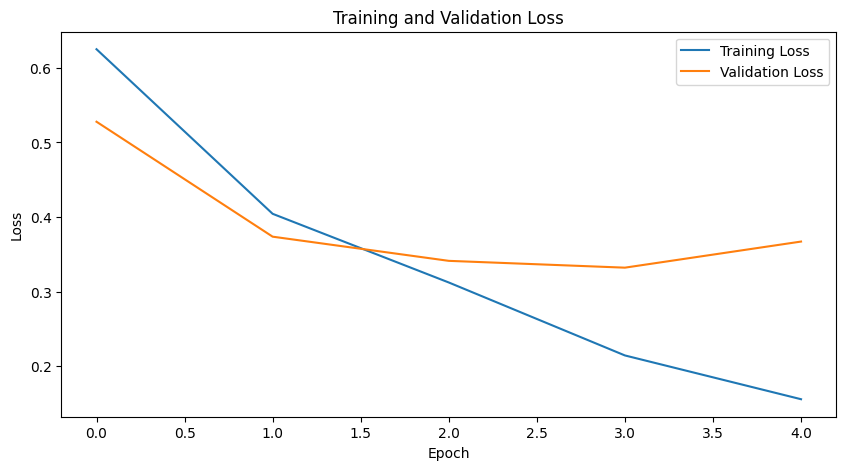

In [105]:
import matplotlib.pyplot as plt
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()




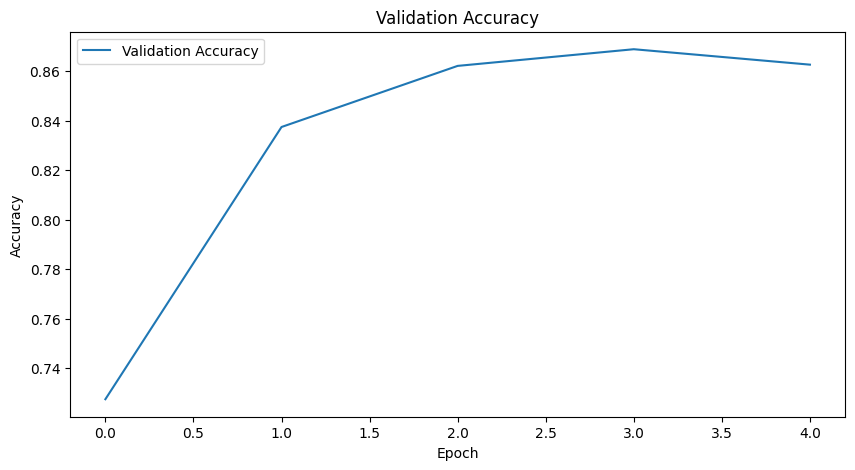

In [106]:
# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# ******LSTM Keeping ALL parameter same**

In [112]:
# Tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Define functions for text preprocessing
def clean(text, tokenizer):
    text = text.lower()
    text = tokenizer.tokenize(text)
    return text

# Create word to index mapping
def get_word2idx(corpus, tokenizer, minlen=100, maxlen=500):
    word2idx = {}
    idx = 1
    for sentence in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):
        sentence = clean(sentence, tokenizer)
        if len(sentence) < minlen or len(sentence) > maxlen:
            continue
        for word in sentence:
            if word not in word2idx:
                word2idx[word] = idx
                idx += 1
    return idx, word2idx

In [113]:
vocab_size, word2idx = get_word2idx(train_dataset['text'], tokenizer)

Creating word2idx: 100%|██████████| 20000/20000 [00:02<00:00, 9128.60it/s]


In [114]:


class IMDBDataset(Dataset):
    def __init__(self, dataset, word2idx, minlen=100, maxlen=500):
        self.dataset = dataset
        self.word2idx = word2idx
        self.minlen = minlen
        self.maxlen = maxlen
        self.count = 0
        self.inputs = []
        self.targets = []

        for idx, sentence in tqdm(enumerate(self.dataset['text']), total=len(self.dataset['text']), desc="Transforming input text"):
            sentence = clean(sentence, tokenizer)
            if len(sentence) < minlen or len(sentence) > maxlen:
                continue
            self.count += 1
            indexed_sentence = [self.word2idx.get(word, 0) for word in sentence]
            self.inputs.append(torch.tensor(indexed_sentence))
            self.targets.append(torch.tensor(self.dataset['label'][idx]))

        # Pad the sentences to maxlen
        self.inputs = pad_sequence(self.inputs, batch_first=True, padding_value=0)

    def __len__(self):
        return self.count

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]


# Create the train, validation, and test datasets
train_ds = IMDBDataset(train_dataset, word2idx)
val_ds = IMDBDataset(val_dataset, word2idx)
test_ds = IMDBDataset(imdb_dataset['test'], word2idx)



Transforming input text: 100%|██████████| 25000/25000 [05:19<00:00, 78.17it/s] 


In [143]:
# Create DataLoader instances
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Define RNN Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        logits = self.fc(output[:, -1, :])
        return logits


In [144]:


# Hyperparameters
embedding_dim = 128
hidden_size = 256
num_classes = 2
learning_rate = 1e-3
num_epochs = 5


# Create the model
model = LSTMModel(vocab_size, embedding_dim, hidden_size, num_classes).to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()





In [145]:

# Model training
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    train_losses = []
    val_losses = []
    val_accuracy = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)
        val_accuracy.append(correct / total)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            #torch.save(model.state_dict(), 'best_model.pth')

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {correct/total:.4f}")

    return train_losses, val_losses, val_accuracy

# Train the model
train_losses, val_losses, val_accuracy = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs)

Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:01<00:00, 85.75it/s]


Epoch 1/5, Train Loss: 0.6941, Val Loss: 0.6935, Val Acc: 0.5100


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:01<00:00, 86.10it/s]


Epoch 2/5, Train Loss: 0.6930, Val Loss: 0.6931, Val Acc: 0.5100


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:01<00:00, 86.06it/s]


Epoch 3/5, Train Loss: 0.6928, Val Loss: 0.6930, Val Acc: 0.5100


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:01<00:00, 86.00it/s]


Epoch 4/5, Train Loss: 0.6926, Val Loss: 0.6930, Val Acc: 0.5100


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:01<00:00, 86.18it/s]

Epoch 5/5, Train Loss: 0.6926, Val Loss: 0.6930, Val Acc: 0.5100


In [146]:
# Test the model
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted== targets).sum().item()
    test_loss /= len(test_loader)
    test_accuracy = correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Load the best model and test it
#model = LSTMModel(vocab_size, embedding_dim, hidden_size,num_layers, num_classes).to(device)
#model.load_state_dict(torch.load('model_lstm.pth'))
test_model(model, test_loader, criterion)


Testing: 100%|██████████| 628/628 [00:07<00:00, 85.73it/s]

Test Loss: 0.6932, Test Accuracy: 0.5095


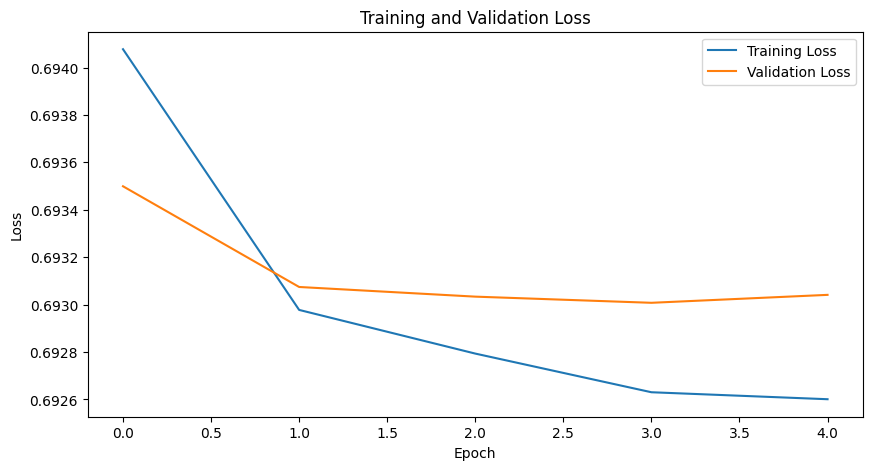

In [147]:
import matplotlib.pyplot as plt
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()




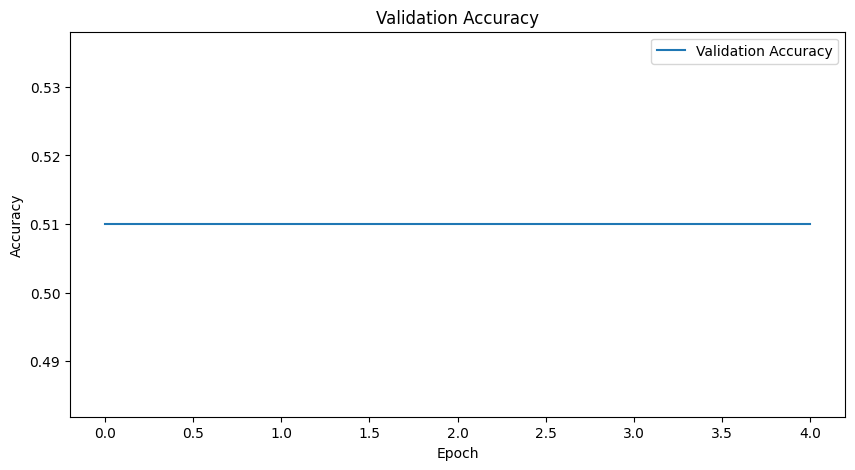

In [148]:
# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

In [149]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
# import nltk
# nltk.download('wordnet')

def clean(text, tokenizer, lemmatizer):
    text = text.lower()
    text = tokenizer.tokenize(text)
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

# Tokenizer and Lemmatizer
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()


In [151]:

# Create word to index mapping
def get_word2idx(corpus, tokenizer, minlen=100, maxlen=500):
    word2idx = {}
    idx = 1
    for sentence in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):
        sentence = clean(sentence, tokenizer, lemmatizer)
        if len(sentence) < minlen or len(sentence) > maxlen:
            continue
        for word in sentence:
            if word not in word2idx:
                word2idx[word] = idx
                idx += 1
    return idx, word2idx


In [152]:
vocab_size, word2idx = get_word2idx(train_dataset['text'], tokenizer)

Creating word2idx: 100%|██████████| 20000/20000 [00:28<00:00, 690.29it/s]


In [154]:

class IMDBDataset(Dataset):
    def __init__(self, dataset, word2idx, minlen=100, maxlen=500):
        self.dataset = dataset
        self.word2idx = word2idx
        self.minlen = minlen
        self.maxlen = maxlen
        self.count = 0
        self.inputs = []
        self.targets = []

        for idx, sentence in tqdm(enumerate(self.dataset['text']), total=len(self.dataset['text']), desc="Transforming input text"):
            sentence = clean(sentence, tokenizer, lemmatizer)
            if len(sentence) < minlen or len(sentence) > maxlen:
                continue
            self.count += 1
            indexed_sentence = [self.word2idx.get(word, 0) for word in sentence]
            self.inputs.append(torch.tensor(indexed_sentence))
            self.targets.append(torch.tensor(self.dataset['label'][idx]))

        # Pad the sentences to maxlen
        self.inputs = pad_sequence(self.inputs, batch_first=True, padding_value=0)

    def __len__(self):
        return self.count

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]


# Create the train, validation, and test datasets
train_ds = IMDBDataset(train_dataset, word2idx)
val_ds = IMDBDataset(val_dataset, word2idx)
test_ds = IMDBDataset(imdb_dataset['test'], word2idx)

Transforming input text: 100%|██████████| 25000/25000 [05:50<00:00, 71.33it/s] 


In [155]:
# Create DataLoader instances
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)



In [159]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        
        # Experiment with only picking the last output
        # logits = self.fc(output[:, -1, :])

        # Experiment with mean of all outputs
        logits = self.fc(output.mean(dim=1))

        return logits


In [160]:

# Hyperparameters
embedding_dim = 128
hidden_size = 256
num_classes = 2
learning_rate = 1e-3
num_epochs = 5

# Create the model
model = LSTMModel(vocab_size, embedding_dim, hidden_size, num_classes).to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()





In [161]:

# Model training
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    train_losses = []
    val_losses = []
    val_accuracy = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)
        val_accuracy.append(correct / total)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'lstm_model.pth')

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {correct/total:.4f}")

    return train_losses, val_losses, val_accuracy

# Train the model
train_losses, val_losses, val_accuracy = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs)


Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:01<00:00, 85.76it/s]


Epoch 1/5, Train Loss: 0.5894, Val Loss: 0.4626, Val Acc: 0.8078


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:01<00:00, 84.90it/s]


Epoch 2/5, Train Loss: 0.3352, Val Loss: 0.3245, Val Acc: 0.8630


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:01<00:00, 84.06it/s]


Epoch 3/5, Train Loss: 0.2059, Val Loss: 0.2902, Val Acc: 0.8829


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:01<00:00, 84.81it/s]


Epoch 4/5, Train Loss: 0.1216, Val Loss: 0.3227, Val Acc: 0.8799


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:01<00:00, 83.72it/s]

Epoch 5/5, Train Loss: 0.0612, Val Loss: 0.3627, Val Acc: 0.8872


In [162]:
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct / total
    return test_loss, test_accuracy

# Load the best model
model.load_state_dict(torch.load('lstm_model.pth'))



test_loss, test_accuracy = test_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Testing: 100%|██████████| 628/628 [00:07<00:00, 84.37it/s]

Test Loss: 0.3075, Test Accuracy: 0.8714


In [163]:
print(model)

LSTMModel(
  (embedding): Embedding(52687, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


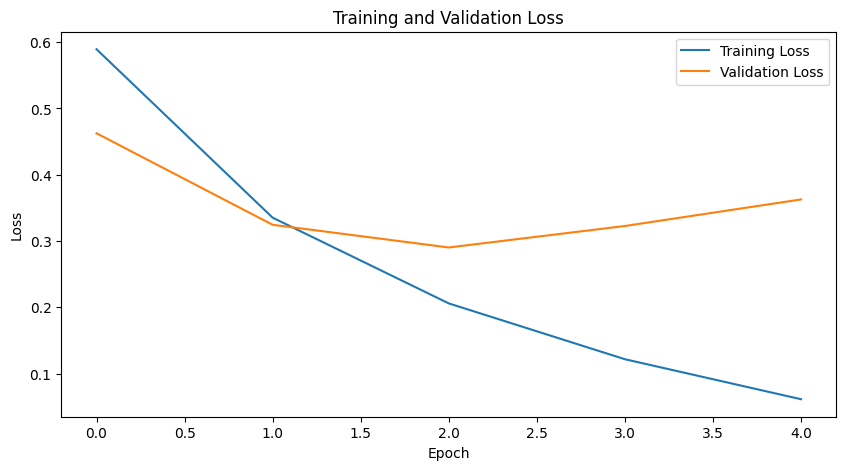

In [165]:
import matplotlib.pyplot as plt
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()




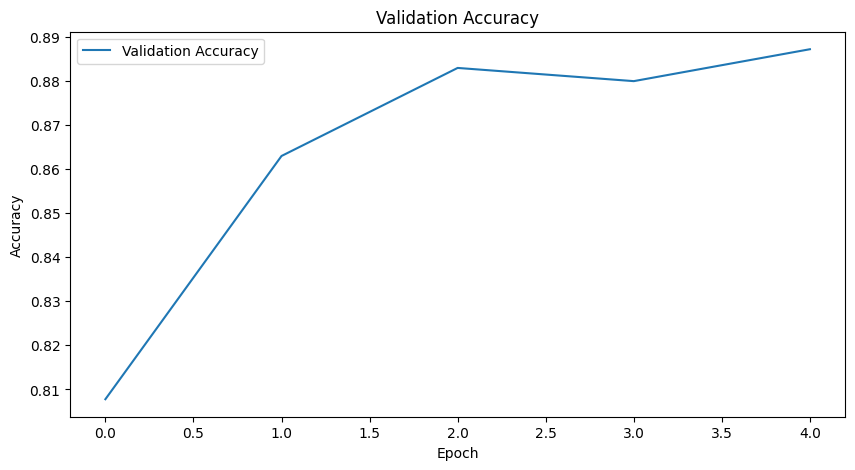

In [166]:
# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# **HYPERPARAMETER TUNNING**

In [172]:
def train_eval_model(embedding_dim, hidden_size, batch_size):
    # Define the model
    model = LSTMModel(vocab_size, embedding_dim, hidden_size, num_classes).to(device)
    
    # Define the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # Train the model
    train_losses, val_losses, val_accuracy = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs)

    return train_losses, val_losses, val_accuracy


In [173]:
hyperparameter_configs = [
    {"embedding_dim": 128, "hidden_size": 256, "batch_size": 32},
    {"embedding_dim": 256, "hidden_size": 512, "batch_size": 64},
    {"embedding_dim": 64, "hidden_size": 128, "batch_size": 16},
    {"embedding_dim": 128, "hidden_size": 512, "batch_size": 128},
    {"embedding_dim": 256, "hidden_size": 128, "batch_size": 64}
]


In [174]:
results = []
for config in hyperparameter_configs:
    embedding_dim = config["embedding_dim"]
    hidden_size = config["hidden_size"]
    batch_size = config["batch_size"]
    
    train_losses, val_losses, val_accuracy = train_eval_model(embedding_dim, hidden_size, batch_size)
    
    result = {
        "embedding_dim": embedding_dim,
        "hidden_size": hidden_size,
        "batch_size": batch_size,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracy": val_accuracy
    }
    results.append(result)

# Analyze the results
for result in results:
    print(f"Embedding Dim: {result['embedding_dim']}, Hidden Size: {result['hidden_size']}, Batch Size: {result['batch_size']}")
    print(f"Validation Accuracy: {max(result['val_accuracy']):.4f}, Validation Loss: {min(result['val_losses']):.4f}\n")


Epoch 1/5 - Validation: 100%|██████████| 126/126 [00:01<00:00, 83.86it/s]


Epoch 1/5, Train Loss: 0.6170, Val Loss: 0.4444, Val Acc: 0.8065


Epoch 2/5 - Validation: 100%|██████████| 126/126 [00:01<00:00, 83.69it/s]


Epoch 2/5, Train Loss: 0.3129, Val Loss: 0.2957, Val Acc: 0.8764


Epoch 3/5 - Validation: 100%|██████████| 126/126 [00:01<00:00, 83.04it/s]


Epoch 3/5, Train Loss: 0.1867, Val Loss: 0.2772, Val Acc: 0.8897


Epoch 4/5 - Validation: 100%|██████████| 126/126 [00:01<00:00, 84.09it/s]


Epoch 4/5, Train Loss: 0.1074, Val Loss: 0.3021, Val Acc: 0.8892


Epoch 5/5 - Validation: 100%|██████████| 126/126 [00:01<00:00, 83.96it/s]


Epoch 5/5, Train Loss: 0.0574, Val Loss: 0.3301, Val Acc: 0.8852


Epoch 1/5 - Validation: 100%|██████████| 63/63 [00:02<00:00, 27.70it/s]


Epoch 1/5, Train Loss: 0.6089, Val Loss: 0.4504, Val Acc: 0.7918


Epoch 2/5 - Validation: 100%|██████████| 63/63 [00:02<00:00, 27.75it/s]


Epoch 2/5, Train Loss: 0.3465, Val Loss: 0.3221, Val Acc: 0.8709


Epoch 3/5 - Validation: 100%|██████████| 63/63 [00:02<00:00, 27.84it/s]


Epoch 3/5, Train Loss: 0.1954, Val Loss: 0.2780, Val Acc: 0.8877


Epoch 4/5 - Validation: 100%|██████████| 63/63 [00:02<00:00, 28.10it/s]


Epoch 4/5, Train Loss: 0.1024, Val Loss: 0.2733, Val Acc: 0.8942


Epoch 5/5 - Validation: 100%|██████████| 63/63 [00:02<00:00, 28.01it/s]


Epoch 5/5, Train Loss: 0.0460, Val Loss: 0.3944, Val Acc: 0.8892


Epoch 1/5 - Validation: 100%|██████████| 251/251 [00:00<00:00, 262.84it/s]


Epoch 1/5, Train Loss: 0.5783, Val Loss: 0.4242, Val Acc: 0.8110


Epoch 2/5 - Validation: 100%|██████████| 251/251 [00:00<00:00, 263.11it/s]


Epoch 2/5, Train Loss: 0.3361, Val Loss: 0.3465, Val Acc: 0.8537


Epoch 3/5 - Validation: 100%|██████████| 251/251 [00:00<00:00, 268.87it/s]


Epoch 3/5, Train Loss: 0.2131, Val Loss: 0.3107, Val Acc: 0.8752


Epoch 4/5 - Validation: 100%|██████████| 251/251 [00:00<00:00, 266.88it/s]


Epoch 4/5, Train Loss: 0.1359, Val Loss: 0.3354, Val Acc: 0.8804


Epoch 5/5 - Validation: 100%|██████████| 251/251 [00:00<00:00, 267.41it/s]


Epoch 5/5, Train Loss: 0.0830, Val Loss: 0.4375, Val Acc: 0.8585


Epoch 1/5 - Validation: 100%|██████████| 32/32 [00:01<00:00, 19.88it/s]


Epoch 1/5, Train Loss: 0.6587, Val Loss: 0.5798, Val Acc: 0.7074


Epoch 2/5 - Validation: 100%|██████████| 32/32 [00:01<00:00, 19.90it/s]


Epoch 2/5, Train Loss: 0.4812, Val Loss: 0.4106, Val Acc: 0.8270


Epoch 3/5 - Validation: 100%|██████████| 32/32 [00:01<00:00, 19.59it/s]


Epoch 3/5, Train Loss: 0.3329, Val Loss: 0.3514, Val Acc: 0.8490


Epoch 4/5 - Validation: 100%|██████████| 32/32 [00:01<00:00, 19.64it/s]


Epoch 4/5, Train Loss: 0.2440, Val Loss: 0.3355, Val Acc: 0.8674


Epoch 5/5 - Validation: 100%|██████████| 32/32 [00:01<00:00, 19.62it/s]


Epoch 5/5, Train Loss: 0.1791, Val Loss: 0.3484, Val Acc: 0.8742


Epoch 1/5 - Validation: 100%|██████████| 63/63 [00:00<00:00, 122.86it/s]


Epoch 1/5, Train Loss: 0.6709, Val Loss: 0.5734, Val Acc: 0.7117


Epoch 2/5 - Validation: 100%|██████████| 63/63 [00:00<00:00, 123.50it/s]


Epoch 2/5, Train Loss: 0.5324, Val Loss: 0.4576, Val Acc: 0.8070


Epoch 3/5 - Validation: 100%|██████████| 63/63 [00:00<00:00, 121.31it/s]


Epoch 3/5, Train Loss: 0.3386, Val Loss: 0.3264, Val Acc: 0.8600


Epoch 4/5 - Validation: 100%|██████████| 63/63 [00:00<00:00, 124.09it/s]


Epoch 4/5, Train Loss: 0.2158, Val Loss: 0.3094, Val Acc: 0.8797


Epoch 5/5 - Validation: 100%|██████████| 63/63 [00:00<00:00, 123.86it/s]

Epoch 5/5, Train Loss: 0.1290, Val Loss: 0.3781, Val Acc: 0.8485
Embedding Dim: 128, Hidden Size: 256, Batch Size: 32
Validation Accuracy: 0.8897, Validation Loss: 0.2772

Embedding Dim: 256, Hidden Size: 512, Batch Size: 64
Validation Accuracy: 0.8942, Validation Loss: 0.2733

Embedding Dim: 64, Hidden Size: 128, Batch Size: 16
Validation Accuracy: 0.8804, Validation Loss: 0.3107

Embedding Dim: 128, Hidden Size: 512, Batch Size: 128
Validation Accuracy: 0.8742, Validation Loss: 0.3355

Embedding Dim: 256, Hidden Size: 128, Batch Size: 64
Validation Accuracy: 0.8797, Validation Loss: 0.3094



In [175]:


def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Testing"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = correct / total
    return accuracy




In [176]:
# Hyperparameters
hyperparameter_configs = [
    {"embedding_dim": 128, "hidden_size": 256, "batch_size": 32},
    {"embedding_dim": 256, "hidden_size": 512, "batch_size": 64},
    {"embedding_dim": 64, "hidden_size": 128, "batch_size": 16},
    {"embedding_dim": 128, "hidden_size": 512, "batch_size": 128},
    {"embedding_dim": 256, "hidden_size": 128, "batch_size": 64}
]

results = []
for config in hyperparameter_configs:
    embedding_dim = config["embedding_dim"]
    hidden_size = config["hidden_size"]
    batch_size = config["batch_size"]
    test_accuracy = evaluate_model(model, test_loader)

    result = {
        "embedding_dim": embedding_dim,
        "hidden_size": hidden_size,
        "batch_size": batch_size,
        "test_accuracy": test_accuracy
    }
    results.append(result)


Testing: 100%|██████████| 628/628 [00:07<00:00, 84.89it/s]


In [179]:
# Analyze the results
for result in results:
    print(f"Embedding Dim: {result['embedding_dim']}, Hidden Size: {result['hidden_size']}, Batch Size: {result['batch_size']}")
    print(f"Test Accuracy: {result['test_accuracy']}")

Embedding Dim: 128, Hidden Size: 256, Batch Size: 32
Test Accuracy: 0.8714015340173324
Embedding Dim: 256, Hidden Size: 512, Batch Size: 64
Test Accuracy: 0.8714015340173324
Embedding Dim: 64, Hidden Size: 128, Batch Size: 16
Test Accuracy: 0.8714015340173324
Embedding Dim: 128, Hidden Size: 512, Batch Size: 128
Test Accuracy: 0.8714015340173324
Embedding Dim: 256, Hidden Size: 128, Batch Size: 64
Test Accuracy: 0.8714015340173324


My Observation 
RNN Classification
Using Tokenization ---> 50.95% Test Accuracy
Using Stemmization  ---> 84.28% Test Accuracy
Slightly improvement but not much 
LSTM Classification
Using Tokenization ---> 51% Test Accuracy
Using Stemmization  ---> 87.14% Test Accuracy

#Even Changing HyperParameter
not too much difference i observed in LSTM


**I I observed when Replace RNN with LSTM
****Replacing the RNN layer with an LSTM layer using nn.LSTM while keeping all other parameters the same can lead to several changes in the model's performance:

Improved Long-Term Dependencies Handling: LSTMs are designed to better capture long-term dependencies in sequential data compared to traditional RNNs. This is achieved through the use of a gating mechanism that allows the network to learn when to forget and update information over time, reducing the vanishing gradient problem.

Reduced Gradient Vanishing/Exploding: LSTMs use a more complex architecture with gating mechanisms (input, forget, and output gates) that help in better gradient flow during training. This can mitigate the issues of vanishing or exploding gradients, which are common in standard RNNs.

Better Memory Capability: The cell state in LSTM allows the model to maintain long-term memory. This can be particularly useful in tasks where remembering long sequences of information is important, such as in language modeling or speech recognition.

Enhanced Performance on Long Sequences: LSTM's ability to retain information over long sequences can lead to improved performance on tasks that involve processing long sequences of data, compared to standard RNNs that struggle with retaining information over long distances.

Overall, the LSTM layer's improvements in handling long-term dependencies and mitigating gradient-related issues can lead to better performance, especially in tasks where capturing long-range dependencies is crucial.**